In [ ]:
import numpy as np
from stdb import load_db 
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import glob, os
import warnings  
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.event.catalog import read_events
warnings.filterwarnings("ignore")  

In [ ]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/02_Station_result_csv'
phase = 'SKS'
# MAG = 6
notplotLIST = ['TRLG','BRNG','GUDG']

SAVEpath = '/Volumes/home/Research/STEP/05_Station_result_statistics'
YearRange= '2010-2015'

In [ ]:
def REstart():
    RCcluster = {'-90-80':[],'-80-70':[],'-70-60':[],'-60-50':[],'-50-40':[],'-40-30':[],'-30-20':[],'-20-10':[],'-1000':[],
      '00-10':[],'10-20':[],'20-30':[],'30-40':[],'40-50':[],'50-60':[],'60-70':[],'70-80':[],'80-90':[]}
    SCcluster = {'-90-80':[],'-80-70':[],'-70-60':[],'-60-50':[],'-50-40':[],'-40-30':[],'-30-20':[],'-20-10':[],'-1000':[],
      '00-10':[],'10-20':[],'20-30':[],'30-40':[],'40-50':[],'50-60':[],'60-70':[],'70-80':[],'80-90':[]}
    return RCcluster,SCcluster
def Calc_rho(RCdt, SCdt):
    rho = RCdt/SCdt 
    return rho
def Calc_Phi(RCPhi, SCPhi):
    Phi = max (abs(RCPhi-SCPhi), abs(SCPhi-RCPhi))
    if Phi > 90: Phi = 180 - Phi
    return Phi
def PolarPlot(ax,title):
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids( range(-90,90+1, 30) )
    ax.set_rticks(range(1,6+1))
    ax.set_rmax(6)
    ax.set_rlabel_position(90)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.set_title(title,fontsize=18,fontweight='bold')
    ax.set_thetamin(-90) # set the limits
    ax.set_thetamax(90)
def dtPlot(ax,dtmean=None,dterror=None):
    ax.set_ylabel('dt (s)',fontsize=15)
    ax.set_xlabel('Backazimuth',fontsize=15)
    ax.set_xlim(0,360)
    ax.set_ylim(0,4.2)
    ax.grid(axis='y',color='lightgrey',lw=1)
    ax.set_yticks(np.arange(0,4.1,0.5))
    ax.set_yticklabels(['0','0.5','1','1.5','2','2.5','3','3.5','Null'])
    ax.set_xticks(range(0,361,30))
    ax.vlines(x=[90,180,270],ymin=0,ymax=4.2,color='lightgrey',lw=1)
    if dtmean != None and dterror != None:
        ax.set_title(f'{round(dtmean,2)}$\pm${round(dterror,2)}(s)',fontsize=15)
def phiPlot(ax):
    ax.set_ylabel('Fast Direction',fontsize=15)
    ax.set_xlabel('Backazimuth',fontsize=15)
    ax.set_xlim(0,360)
    ax.set_ylim(-90,90)
    ax.grid(axis='y',color='lightgrey',lw=1)
    ax.set_xticks(range(0,361,30))
    ax.vlines(x=[90,180,270],ymin=-90,ymax=90,color='lightgrey',lw=1)
def Cluster(Phi):
    phii = Phi//10
    if phii >=0:
        start = f'{int(phii)}0'
        end = f'{int(phii+1)}0'
        strr = f'{start}-{end}'
    else: 
        start = f'{int(phii)}0'
        end = f'{int(phii+1)}0' 
        strr = f'{start}{end}'
    return strr

def angle_mean(dt, phi, ddt, dphi):
    dt=np.array(dt)
    phi=np.array(phi)
    ddt=np.array(ddt)
    dphi=np.array(dphi)
    x = dt*np.cos(2*phi*np.pi/180.0)
    y = dt*np.sin(2*phi*np.pi/180.0)
    c = x + 1j*y
    m = np.mean(c)

    phase = np.angle(m, deg=True)/2.
    radius = np.abs(m)
    dphase = np.sqrt(np.sum(dphi**2))/len(x)
    dradius = np.sqrt(np.sum(ddt**2))/len(x)

    return phase, dphase, radius, dradius


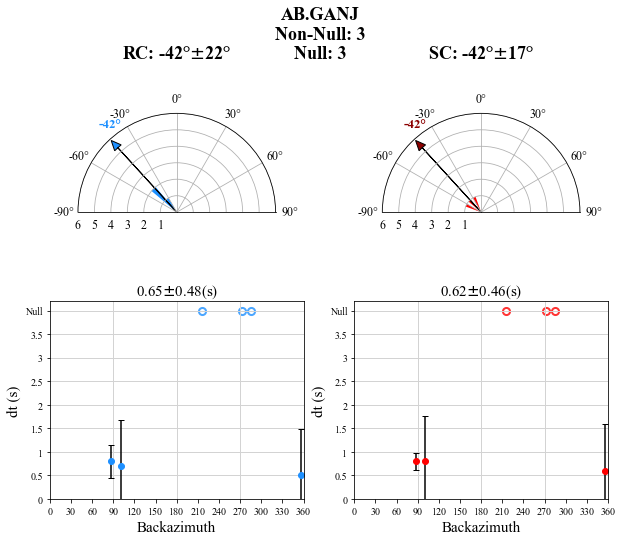

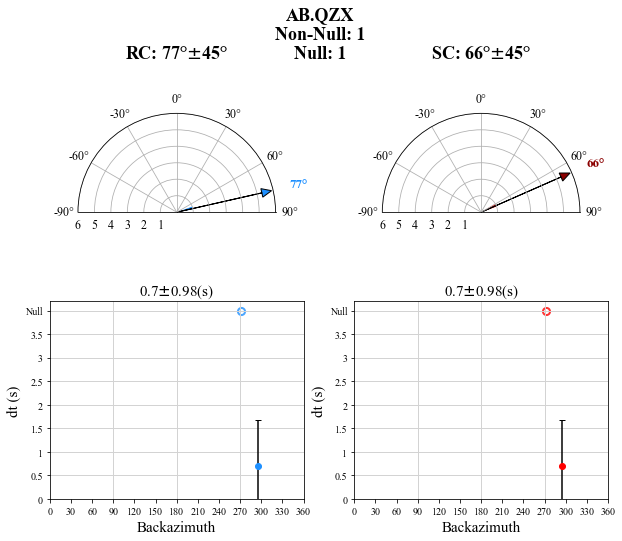

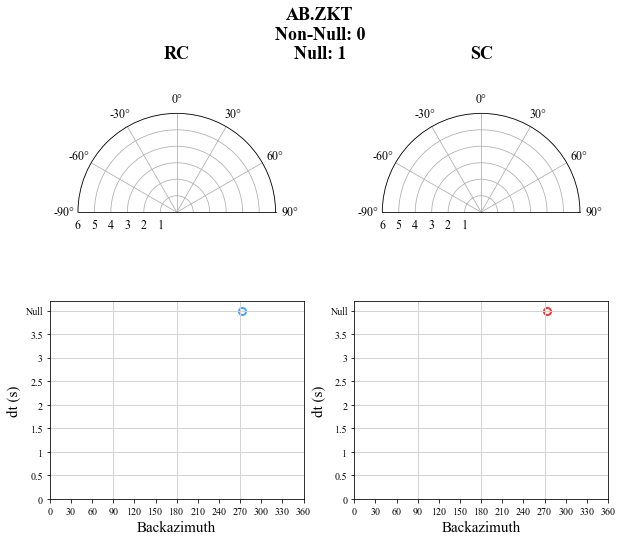

In [5]:
width = (2*np.pi) / 36
allSTA = {'Station':[],
         'RCphi':[],'RCdphi':[],
         'RCdt':[],'RCddt':[],
         'SCphi':[],'SCdphi':[],
         'SCdt':[],'SCddt':[],
         'nonNull':[],'Null':[]}

for STApath in glob.glob(f'{PKLpath}/AB*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
#     print(f'{NET}.{STA}')    
    allSTA['Station'].append(f'{NET}.{STA}')
    stlat = values['latitude']; stlon = values['longitude']
    RCcluster,SCcluster = REstart()
    phiRC = []; DphiRC = []; dtRC = []; DdtRC = []
    phiSC = []; DphiSC = []; dtSC = []; DdtSC = []
    BAZ = []; 
    NULLBAZ_G = [] ; NULLdt_G = []; NULLBAZ_F = [] ; NULLdt_F = []
    plt.rc('font',family='Times New Roman')
    plt.figure(figsize=(10,8))
    ax1 = plt.subplot(221, polar=True)
    ax2 = plt.subplot(222, polar=True)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)
    for csvpath in glob.glob(f'{Path}/{NET}*{STA}*.csv'):
#         print(csvpath)
        df = pd.read_csv(csvpath)
        df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]#[df['Mag']<7]

        
        for i in range(len(df)):
            evlat = df['Ev_lat'].values[i]
            evlon = df['Ev_lon'].values[i]
            
            RCPhi = df['RCPhi'].values[i]
            RCDPhi  = df['RCPhi_std'].values[i]
            RCdt  = df['RCdt'].values[i]
            RCDdt  = df['RCdt_std'].values[i]
            SCPhi = df['SCPhi'].values[i]
            SCDPhi  = df['SCPhi_std'].values[i]
            SCdt  = df['SCdt'].values[i]
            SCDdt  = df['SCdt_std'].values[i]

            rho = Calc_rho(RCdt, SCdt)
            phi = Calc_Phi(RCPhi, SCPhi)
            
            dist, az, baz = gps2dist_azimuth(evlat,evlon,stlat,stlon)
            if 30 < phi < 68 or df["CpH"].values[i] > 0.76 :
                NULLBAZ_G.append(baz)
                NULLdt_G.append(4)
            elif 0.8 < rho < 1.1 and phi < 8:## non-null good condition 
#                 print(df['Event'].values[i])
                phiRC.append(float(RCPhi));DphiRC.append(float(RCDPhi));dtRC.append(float(RCdt));DdtRC.append(float(RCDdt))
                phiSC.append(float(SCPhi));DphiSC.append(float(SCDPhi));dtSC.append(float(SCdt));DdtSC.append(float(SCDdt))
                RCstr = Cluster(RCPhi)
                SCstr = Cluster(SCPhi)
                RCcluster[RCstr].append(RCPhi)
                SCcluster[SCstr].append(SCPhi)
                BAZ.append(baz)
            elif 0.7 <= rho < 1.2 and phi <= 25: ## non-null FAIR condition 
#                 print(df['Event'].values[i])
                phiRC.append(float(RCPhi));DphiRC.append(float(RCDPhi));dtRC.append(float(RCdt));DdtRC.append(float(RCDdt))
                phiSC.append(float(SCPhi));DphiSC.append(float(SCDPhi));dtSC.append(float(SCdt));DdtSC.append(float(SCDdt))
                RCstr = Cluster(RCPhi)
                SCstr = Cluster(SCPhi)
                RCcluster[RCstr].append(RCPhi)
                SCcluster[SCstr].append(SCPhi)
                BAZ.append(baz)
            else: pass
            

    for key in SCcluster.keys():
        length = len(SCcluster[key])
        if length >0:
            if key != '-1000': num = key.rsplit('-',1)[0]
            else: num = '-10'
            PLOTPhi = int(num)+5 
            ax2.bar(PLOTPhi*np.pi/180, length , width=width, color='red')
    for key in RCcluster.keys():
        length = len(RCcluster[key])
        if length >0:
            if key != '-1000': num = key.rsplit('-',1)[0]
            else: num = '-10'
#             num = key.rsplit('-',1)[0]
            PLOTPhi = int(num)+5 
            ax1.bar(PLOTPhi*np.pi/180, length , width=width, color='dodgerblue')
#####============non-Null 
    if len(dtRC) > 0:
        meanphiRC, stdphiRC, meandtRC, stddtRC = angle_mean(dtRC, phiRC, DdtRC, DphiRC)
        meanphiSC, stdphiSC, meandtSC, stddtSC = angle_mean(dtSC, phiSC, DdtSC, DphiSC)
        allSTA['RCphi'].append(round(meanphiRC)); allSTA['RCdphi'].append(round(stdphiRC))
        allSTA['RCdt'].append(float(round(meandtRC,2))); allSTA['RCddt'].append( float(round(stddtRC,2)))
        allSTA['SCphi'].append(round(meanphiSC)); allSTA['SCdphi'].append(round(stdphiSC))
        allSTA['SCdt'].append(float(round(meandtSC,2))); allSTA['SCddt'].append( float(round(stddtSC,2)))
###============Fast direction        
        ax1.arrow(meanphiRC*np.pi/180,0,0,5.3, head_width=0.1,head_length=0.6,fc='dodgerblue',ec='k')
        ax1.text(meanphiRC*np.pi/180,7,f'{round(meanphiRC)}°',fontsize=13,color='dodgerblue',fontweight='bold')
        ax2.arrow(meanphiSC*np.pi/180,0,0,5.3, head_width=0.1,head_length=0.6,fc='darkred',ec='k')
        ax2.text(meanphiSC*np.pi/180,7,f'{round(meanphiSC)}°',fontsize=13,color='darkred',fontweight='bold')
        PolarPlot(ax1,title = f'RC: {round(meanphiRC)}°$\pm${round(stdphiRC)}°')
        PolarPlot(ax2,title = f'SC: {round(meanphiSC)}°$\pm${round(stdphiSC)}°')
###============dt         
        dtPlot(ax3,meandtRC,stddtRC)
        dtPlot(ax4,meandtSC,stddtSC)
        ax3.errorbar(BAZ,dtRC,yerr=DdtRC,fmt='o',color ='dodgerblue' ,ecolor='k',capsize=3)
        plt.subplot(223)
        plt.scatter(NULLBAZ_G,NULLdt_G,marker='o',edgecolors='dodgerblue',linewidths=2,alpha=0.8,s=50,c='1')
        plt.scatter(NULLBAZ_F,NULLdt_F,marker='d',edgecolors='dodgerblue',linewidths=2,alpha=0.4,s=50,c='1')
        ax4.errorbar(BAZ,dtSC,yerr=DdtSC,fmt='o',color ='red' ,ecolor='k',capsize=3)
        plt.subplot(224)
        plt.scatter(NULLBAZ_G,NULLdt_G,marker='o',edgecolors='red',linewidths=2,alpha=0.8,s=50,c='1')
        plt.scatter(NULLBAZ_F,NULLdt_F,marker='d',edgecolors='red',linewidths=2,alpha=0.4,s=50,c='1')
#####============Null  
    else:
        dtPlot(ax3)
        dtPlot(ax4) 
        plt.subplot(223)
        plt.scatter(NULLBAZ_G,NULLdt_G,marker='o',edgecolors='dodgerblue',linewidths=2,alpha=0.8,s=50,c='1')
        plt.scatter(NULLBAZ_F,NULLdt_F,marker='d',edgecolors='dodgerblue',linewidths=2,alpha=0.4,s=50,c='1')
        plt.subplot(224)
        plt.scatter(NULLBAZ_G,NULLdt_G,marker='o',edgecolors='red',linewidths=2,alpha=0.8,s=50,c='1')
        plt.scatter(NULLBAZ_F,NULLdt_F,marker='d',edgecolors='red',linewidths=2,alpha=0.4,s=50,c='1')
      
        allSTA['RCphi'].append(np.NaN); allSTA['RCdphi'].append(np.NaN)
        allSTA['RCdt'].append(np.NaN); allSTA['RCddt'].append(np.NaN)
        allSTA['SCphi'].append(np.NaN); allSTA['SCdphi'].append(np.NaN)
        allSTA['SCdt'].append(np.NaN); allSTA['SCddt'].append(np.NaN)
        PolarPlot(ax1,title = f'RC')
        PolarPlot(ax2,title = f'SC')        
    plt.suptitle(f'{NET}.{STA}\nNon-Null: {len(phiRC)}\nNull: {len(NULLBAZ_F)+len(NULLBAZ_G)}',fontsize=18,fontweight='bold')
    allSTA['Null'].append(len(NULLBAZ_F)+len(NULLBAZ_G))
    allSTA['nonNull'].append(len(phiRC))
#     plt.savefig(f'{SAVEpath}/{NET}.{STA}/{NET}.{STA}_meanphidt.png',facecolor='white')
#     plt.savefig(f'{SAVEpath}/{NET}.{STA}/{NET}.{STA}_meanphidt.pdf')
#     plt.close()
# stadf = pd.DataFrame(allSTA)
# stadf.to_csv(f'{SAVEpath}/Station_SKS_{YearRange}average.csv',index=False)


In [ ]:
width = (2*np.pi) / 36
allSTA = {'Station':[],
         'RCphi':[],'RCdphi':[],
         'RCdt':[],'RCddt':[],
         'SCphi':[],'SCdphi':[],
         'SCdt':[],'SCddt':[],
         'nonNull':[],'Null':[]}

for STApath in glob.glob(f'{PKLpath}/AB*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
#     print(f'{NET}.{STA}')    
    allSTA['Station'].append(f'{NET}.{STA}')
    stlat = values['latitude']; stlon = values['longitude']
    for csvpath in glob.glob(f'{Path}/{NET}*{STA}*.csv'):
#         print(csvpath)
        df = pd.read_csv(csvpath)
        df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]#[df['Mag']<7]

        
        for i in range(len(df)):
            evlat = df['Ev_lat'].values[i]
            evlon = df['Ev_lon'].values[i]
            
            RCPhi = df['RCPhi'].values[i]
            RCDPhi  = df['RCPhi_std'].values[i]
            RCdt  = df['RCdt'].values[i]
            RCDdt  = df['RCdt_std'].values[i]
            SCPhi = df['SCPhi'].values[i]
            SCDPhi  = df['SCPhi_std'].values[i]
            SCdt  = df['SCdt'].values[i]
            SCDdt  = df['SCdt_std'].values[i]

            rho = Calc_rho(RCdt, SCdt)
            phi = Calc_Phi(RCPhi, SCPhi)
            
            dist, az, baz = gps2dist_azimuth(evlat,evlon,stlat,stlon)
            if 30 < phi < 68 or df["CpH"].values[i] > 0.76 :
                pass
            elif 0.8 < rho < 1.1 and phi < 8:## non-null good condition 
                pass
            elif 0.7 <= rho < 1.2 and phi <= 25: ## non-null FAIR condition 
                pass
            else: pass
            
